
[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



25/05/06 14:48:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Test Accuracy: 1.0000


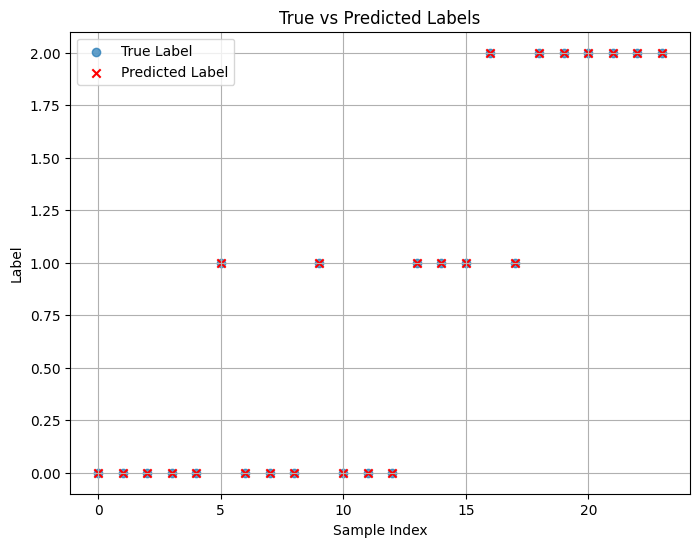

In [2]:
# Step 1: Set up the environment
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request

# Start Spark session
spark = SparkSession.builder.appName("IrisClassification").getOrCreate()

# Step 2: Load and explore the dataset
# Download dataset using urllib
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_file = "iris.csv"
urllib.request.urlretrieve(iris_url, iris_file)

# Load dataset
columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]
iris_df = spark.read.csv("iris.csv", inferSchema=True).toDF(*columns)

# Show first few rows
iris_df.show(5)

# Step 3: Data Preprocessing
# Convert label (species) into numeric using StringIndexer
indexer = StringIndexer(inputCol="species", outputCol="label")
iris_indexed = indexer.fit(iris_df).transform(iris_df)

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"],
    outputCol="features"
)
iris_prepared = assembler.transform(iris_indexed).select("features", "label")

# Step 4: Split the dataset
train_data, test_data = iris_prepared.randomSplit([0.8, 0.2], seed=42)

# Step 5: Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_model = lr.fit(train_data)

# Step 6: Evaluate the model
predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 7: Visualize the results
# Convert to Pandas for visualization
pred_pd = predictions.select("label", "prediction").toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(pred_pd.index, pred_pd["label"], label="True Label", alpha=0.7)
plt.scatter(pred_pd.index, pred_pd["prediction"], label="Predicted Label", marker='x', color='red')
plt.title("True vs Predicted Labels")
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.legend()
plt.grid(True)
plt.show()
